# Herron Topic 5 - Practice for Section 04

##  Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import yfinance as yf

In [2]:
%precision 2
pd.options.display.float_format = '{:.2f}'.format
%config InlineBackend.figure_format = 'retina'

### Estimate $\pi$ by simulating darts thrown at a dart board

*Hints:*
Select random $x$s and $y$s such that $-r \leq x \leq +r$ and $-r \leq x \leq +r$.
Darts are on the board if $x^2 + y^2 \leq r^2$.
The area of the circlular board is $\pi r^2$, and the area of square around the board is $(2r)^2 = 4r^2$.
The fraction $f$ of darts on the board is the same as the ratio of circle area to square area, so $f = \frac{\pi r^2}{4 r^2}$.

First we throw darts at the board.
Darts with $x^2 + y^2 \leq r^2$ are on the board.

In [3]:
def throw_darts(n=10_000, r=1, seed=42):
    np.random.seed(seed)
    return (
        pd.DataFrame(
            data=np.random.uniform(low=-r, high=r, size=2*n).reshape(n, 2), 
            columns=['x', 'y']
        )
        .assign(board=lambda x: x['x']**2 + x['y']**2 <= r**2)
        .rename_axis(index='n', columns='Variable')
    )

In [4]:
throw_darts()

Variable,x,y,board
n,,,
0,-0.25,0.90,True
1,0.46,0.20,True
2,-0.69,-0.69,True
3,-0.88,0.73,False
4,0.20,0.42,True
...,...,...,...
9995,0.15,0.52,True
9996,-0.82,-0.01,True
9997,0.80,0.75,False


Next, we visualize these darts with a scatter plot.
Seaborn's `scatterplot()` helps color darts by location (i.e., on or off board).
The `.pipe()` method lets us send the output of the `.assign()` method to `sns.scatterplot()` without assigning a temporary data frame.

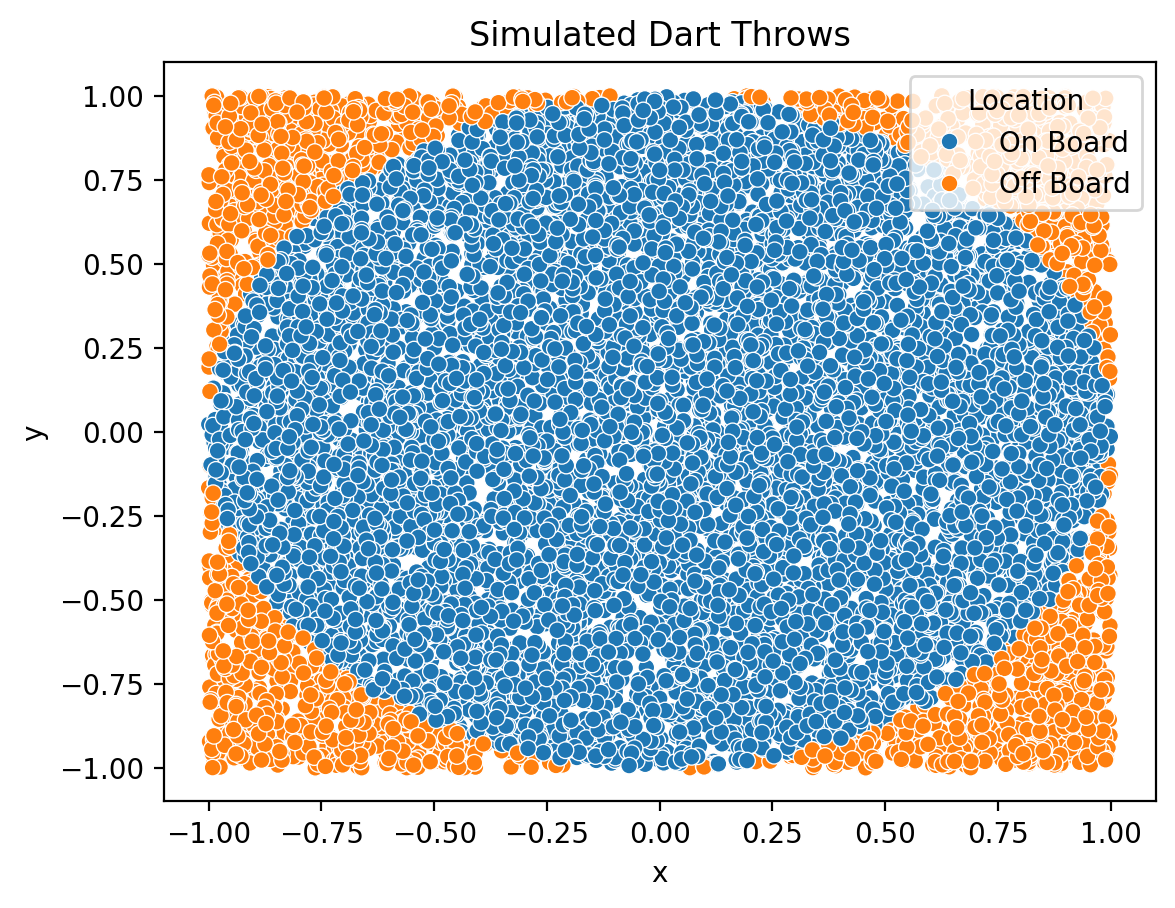

In [5]:
(
    throw_darts()
    .assign(Location=lambda x: np.where(x['board'], 'On Board', 'Off Board'))
    .pipe(lambda x: sns.scatterplot(data=x, x='x', y='y', hue='Location'))
)
plt.title('Simulated Dart Throws')
plt.show()

Finally, we use the hint above to estimate $\pi$.
The hint above says $f = \frac{\pi r^2}{4 r^2}$, where $f$ is the fraction of darts on the board.
Therefore, $\pi = \frac{4fr^2}{r^2} = 4f$.

In [6]:
n = 10_000
pi = 4 * throw_darts(n=n)["board"].mean()
print(f'Estimate of pi based on {n:,.0f} darts: {pi:0.4f}')

Estimate of pi based on 10,000 darts: 3.1544


We increase the precision of our $\pi$ estimate by increasing the number of simulated darts $n$.

In [7]:
for n in 10**np.arange(7):
    pi = 4 * throw_darts(n=n)["board"].mean()
    print(f'Estimate of pi based on {n:<9,.0f} darts: {pi:0.4f}')

Estimate of pi based on 1         darts: 4.0000
Estimate of pi based on 10        darts: 3.2000
Estimate of pi based on 100       darts: 3.0400
Estimate of pi based on 1,000     darts: 3.1040
Estimate of pi based on 10,000    darts: 3.1544
Estimate of pi based on 100,000   darts: 3.1468
Estimate of pi based on 1,000,000 darts: 3.1420


### Simulate your wealth $W_T$ by randomly sampling market returns

Use monthly market returns from the French Data Library.
Only invest one cash flow $W_0$, and plot the distribution of $W_T$.

First, we download data from the French Data Library.
We convert these returns from percent to decimal to simplify compounding.

In [8]:
mkt = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900'
    )[0]
    .assign(mkt=lambda x: (x['Mkt-RF'] + x['RF']) / 100)
    ['mkt']
)

C:\Users\r.herron\AppData\Local\Temp\ipykernel_13960\526361920.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


Next, we write a couple of helper functions.
The `get_sample()` function draws one random sample of `n` observations from returns series `x`.
This sample provides one simulated return history.

In [9]:
pd.date_range

<function pandas.core.indexes.datetimes.date_range(start=None, end=None, periods=None, freq=None, tz=None, normalize: 'bool' = False, name: 'Hashable | None' = None, inclusive: 'IntervalClosedType' = 'both', *, unit: 'str | None' = None, **kwargs) -> 'DatetimeIndex'>

In [10]:
def get_sample(x, n=10_000, seed=42, start=None):
    if start is None:
        start = x.index[-1] + pd.offsets.BDay()
    return (
        x
        .sample(n=n, replace=True, random_state=seed, ignore_index=True)
        .set_axis(pd.date_range(start=start, periods=n, freq='B'))
        .rename_axis(index='Date')
    )    

The `get_samples()` function calls the `get_sample()` function `m` times to simulate `m` return histories.
The `get_samples()` function combines these `m` return histories into one data frame.

In [11]:
def get_samples(x, m=100, n=10_000, seed=42, start=None):
    return (
        pd.concat(
            objs=[get_sample(x=x, n=n, seed=seed+i, start=start) for i in range(m)],
            axis=1,
            keys=range(m),
            names='Sample'
        )
    )

Next, we use these helper functions to simulate 100 return histories of 10,000 trading days each.

In [12]:
mkts = get_samples(x=mkt, m=100, n=10_000)
mkts

Sample,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,0.00,0.01,0.00,0.00,0.00,0.00,-0.00,0.00,-0.01,0.00,...,0.01,0.01,0.00,0.01,0.00,0.00,-0.00,-0.01,-0.01,0.00
2024-03-04,0.01,-0.00,0.00,0.01,0.00,-0.01,-0.01,0.01,0.00,-0.01,...,-0.00,0.00,0.01,-0.02,0.00,0.01,0.01,0.01,-0.01,-0.01
2024-03-05,-0.03,-0.00,-0.01,-0.03,-0.00,0.02,-0.00,0.00,-0.01,-0.01,...,0.00,-0.00,0.01,-0.02,-0.01,0.01,-0.00,0.00,-0.00,0.01
2024-03-06,-0.00,-0.00,-0.01,-0.00,0.01,0.01,0.00,-0.02,0.00,-0.01,...,0.01,-0.01,0.00,0.00,0.00,-0.02,-0.02,0.00,-0.00,0.01
2024-03-07,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,0.01,0.01,-0.00,0.01,...,0.00,-0.00,0.01,-0.01,-0.01,-0.03,-0.00,-0.01,-0.03,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2062-06-23,-0.01,0.00,0.00,0.00,0.00,0.03,-0.01,0.00,-0.00,0.01,...,-0.01,-0.01,0.00,0.00,-0.00,-0.07,0.01,0.02,-0.00,-0.00
2062-06-26,-0.00,0.01,-0.00,0.01,0.00,-0.01,0.01,0.00,-0.00,-0.00,...,0.00,-0.00,-0.01,-0.00,-0.01,0.00,0.01,0.01,0.03,-0.01
2062-06-27,-0.01,-0.01,0.02,-0.04,0.00,0.01,0.00,0.00,0.00,0.01,...,0.00,-0.00,-0.01,0.01,0.00,0.01,0.01,0.01,0.00,0.01


We compound daily returns $R_t$ to find future wealth $W_T$, so $W_T = W_0 \times (1 + R_1) \times (1 + R_2) \times \cdots \times (1 + R_T)$.
We use the `.cumprod()` method to compound the daily returns in data frame `mkts`.

In [13]:
W_0 = 1_000_000
W_t = W_0 * mkts.add(1).cumprod()

We visualize terminal wealth $W_T$ with a cumulative distribution plot.

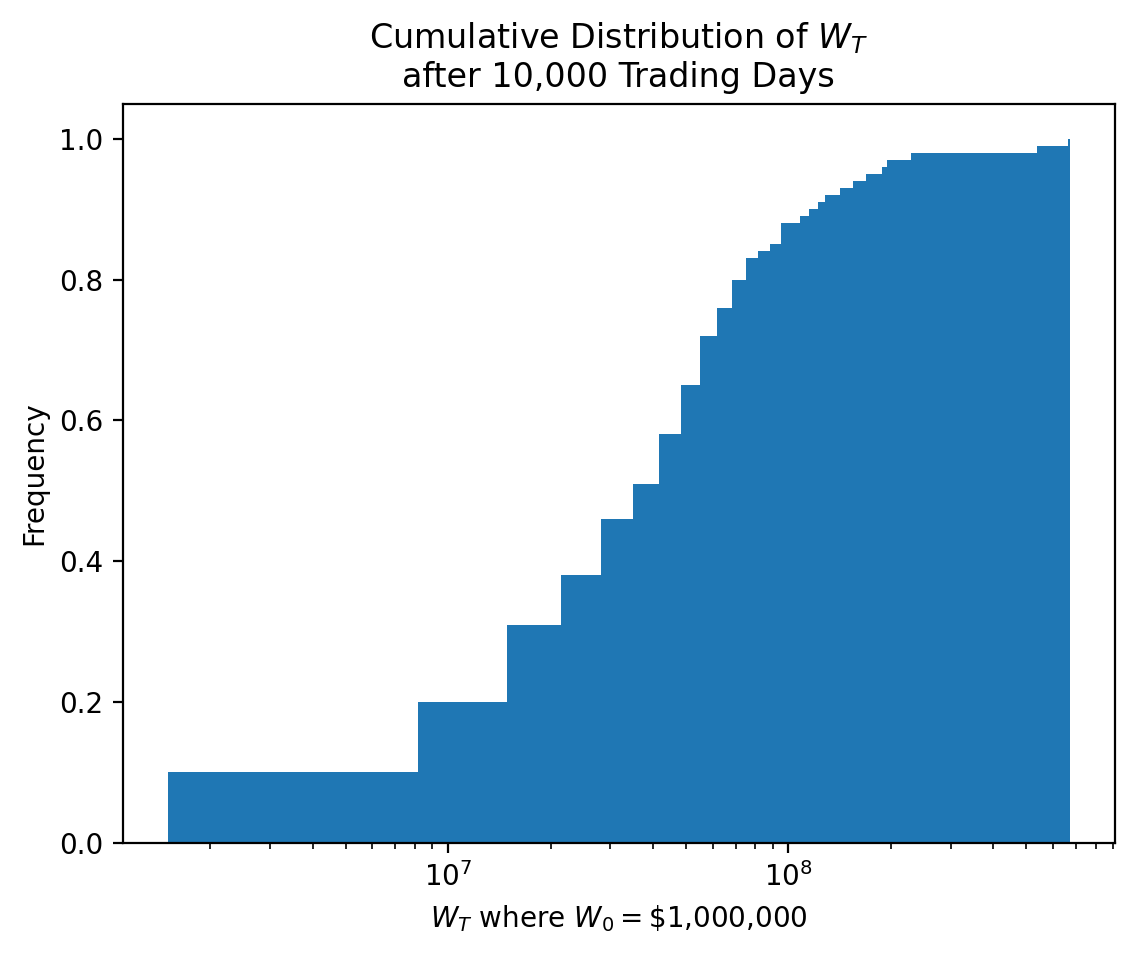

In [14]:
W_t.iloc[-1].plot(kind='hist', density=True, cumulative=True, bins=100)
plt.semilogx()
plt.xlabel(r'$W_T$ where $W_0 = $' + f'\\${W_0:,.0f}')
plt.title(r'Cumulative Distribution of $W_T$' + f'\nafter {W_t.shape[0]:,.0f} Trading Days')
plt.show()

The plot above shows the cumulative distribution of $W_T$, suggesting we expect $W_T$ greater than about 20 million dollars for about 75% of samples.
The plot above may be difficult to read and interpret because $W_T$ has large outliers.
The `.describe()` method provides few salient values of $W_T$.
We convert $W_T$ from dollars to millions of dollars with `.div(1_000_000)`.

In [15]:
W_t.iloc[-1].div(1_000_000).describe()

count   100.00
mean     61.07
std      90.71
min       1.50
25%      18.12
50%      41.47
75%      66.93
max     669.23
Name: 2062-06-29 00:00:00, dtype: float64

### Repeat the exercise above but add end-of-month investments $C_t$

We can use the same data frame `mkts` of simulated market returns.
However, need to consider end-of-month investments of $C_t$.
The easiest approach is to aggregate the daily market returns in `mkts` to monthly market returns in data frame `mkts_m`.

In [16]:
mkts_m = (
    mkts
    .add(1)
    .resample(rule='M', kind='period')
    .prod()
    .sub(1)
)

The wealth at time $t$ is $W_t$ and depends on:

1. The wealth at the end of the previous month $W_{t-1}$
1. The return over the previous month $R_t$ (recall we label returns by their right edge)
1. The end-of-month investment $C_t$

Putting it all togther: $W_t = W_{t-1} \times (1 + R_t) + C_t$

We have to loop over the monthly returns in `mkts_m` because we have to combine compounded returns and cash flows.
The `iterrows()` methods provides an easy way to iterate (loop) over the rows in `mkts_m`.

In [17]:
C_t = 1_000
W_0 = 1_000_000
W_last = W_0
W_t = []

for d, m in mkts_m.iterrows():
    W_last = (1 + m) * W_last + C_t
    W_t.append(W_last)

W_t = pd.concat(objs=W_t, axis=1, keys=mkts_m.index).transpose()

We repeat the cumulative distribution of wealth plot and descriptive statistics from above.

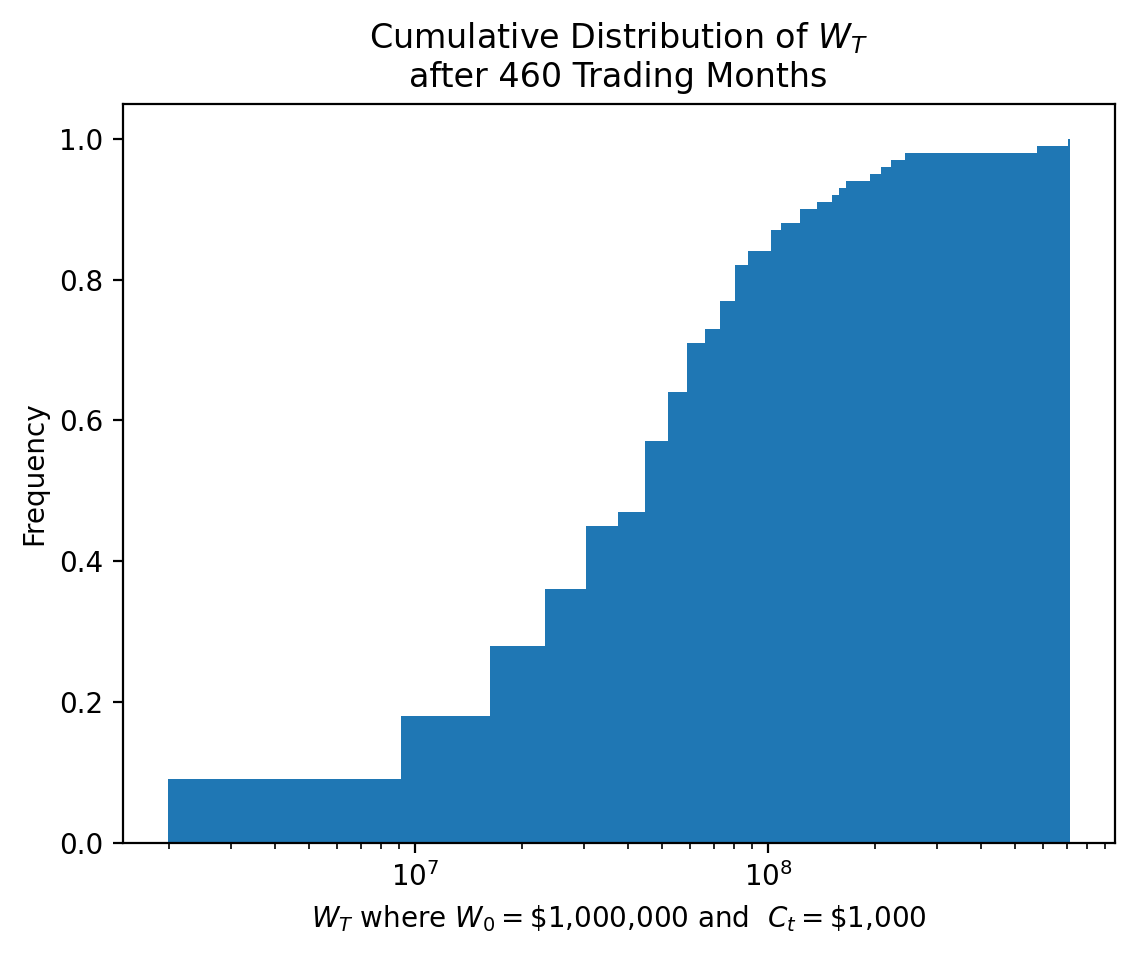

In [18]:
W_t.iloc[-1].plot(kind='hist', density=True, cumulative=True, bins=100)
plt.semilogx()
plt.xlabel(
    r'$W_T$ where $W_0 = $' + f'\\${W_0:,.0f}' + 
    r' and  $C_t = $' + f'\\${C_t:,.0f}'
)
plt.title(r'Cumulative Distribution of $W_T$' + f'\nafter {W_t.shape[0]:,.0f} Trading Months')
plt.show()

In [19]:
W_t.iloc[-1].div(1_000_000).describe()

count   100.00
mean     67.84
std      97.55
min       1.99
25%      21.21
50%      46.54
75%      75.92
max     713.85
Name: 2062-06, dtype: float64

The plot above shows the cumulative distribution of $W_T$, suggesting we expect $W_T$ greater than about 20 million dollars for about 75% of samples.
Note, even though we deposit $1,000 per month for almost 40 years, we do not gain much wealth over the previous example with only a lump sum!
Start saving early!